# Table of Contents
* [1. Plamsa Profiles](#1.-Plamsa-Profiles)
* [2. Test Case 1. Converging Beam](#2.-Test-Case-1.-Converging-Beam)
* [3. Test Case 2. Near Cutoff Behavior](#3.-Test-Case-2.-Near-Cutoff-Behavior)
	* [3.1 Finite $k_z$](#3.1-Finite-$k_z$)
	* [3.2 Finite $k_x'/k_x^2$](#3.2-Finite-$k_x'/k_x^2$)


In [1]:
# Some initial setups
from __future__ import print_function
import sys

import numpy as np
from scipy.integrate import trapz, cumtrapz
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import rcParams

from FPSDP.GeneralSettings.UnitSystem import cgs
import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
import FPSDP.Diagnostics.ECEI.ECEI2D.Reciprocity as rcp
from FPSDP.Diagnostics.ECEI.ECEI2D.Detector2D import GaussianAntenna
import FPSDP.Plasma.PlasmaCharacter as pc


%matplotlib inline

rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 18

c = cgs['c']
keV = cgs['keV']
e = cgs['e']
me = cgs['m_e']
pi = np.pi
twopi = 2*np.pi

# We will use a uniform Te profile to do the benchmarks
Te0 = 10*keV
ne0 = 2e13
tp.set_parameter2D(Te_0 = Te0, ne_0=ne0, Te_shape='uniform', ne_shape='linear')
p2d_uni = tp.create_profile2D()
p2d_uni.setup_interps()

# 1. Plamsa Profiles

We have a cylindrical plasma with the following parameters:

In [2]:
tp.show_parameter2D()

R_0 : 200
a : 50
DownLeft : (-30, 150)
UpRight : (30, 300)
NR : 601
NZ : 720
ne_0 : 2e+13
Te_0 : 1.6022e-08
B_0 : 20000
ne_shape : linear
Te_shape : uniform
dne_ne : 0.01
dte_te : 0.01
dB_B : 0
siny : {'y0': 0, 'k': 21, 'omega': 628000.0, 'x0': 220, 'dx': 5}
sinx : {'y0': 0, 'k': 6.28, 'omega': 628000.0, 'x0': 220, 'dy': 20}
timesteps : [0, 1, 2, 3]
dt : 2.5e-06


In [3]:
print(p2d_uni.physical_quantities())

Equilibrium:
    Electron density: ne0 (max: 2e+13, min:2e+03 cm^-3)
    Electron temperature: Te0 (max:10.0, min:10.0 keV)
    Magnetic field: B0 (max:2.67e+04, min:1.33e+04 Gauss)
Fluctuation:



Mid-plane profiles look like:

In [4]:
R1D = p2d_uni.grid.R1D
mid_Z = p2d_uni.grid.NZ/2

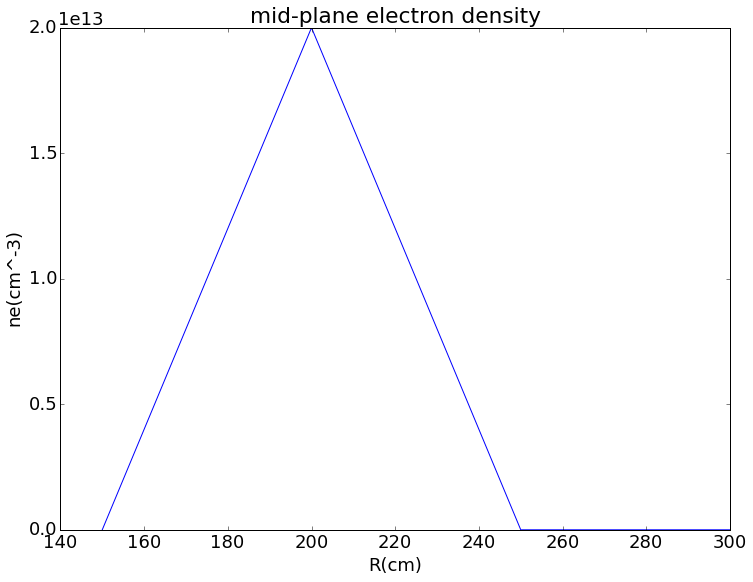

In [5]:
plt.figure()
plt.plot(R1D, p2d_uni.ne0[mid_Z, :])
plt.title('mid-plane electron density')
plt.ylabel('ne(cm^-3)')
plt.xlabel('R(cm)')

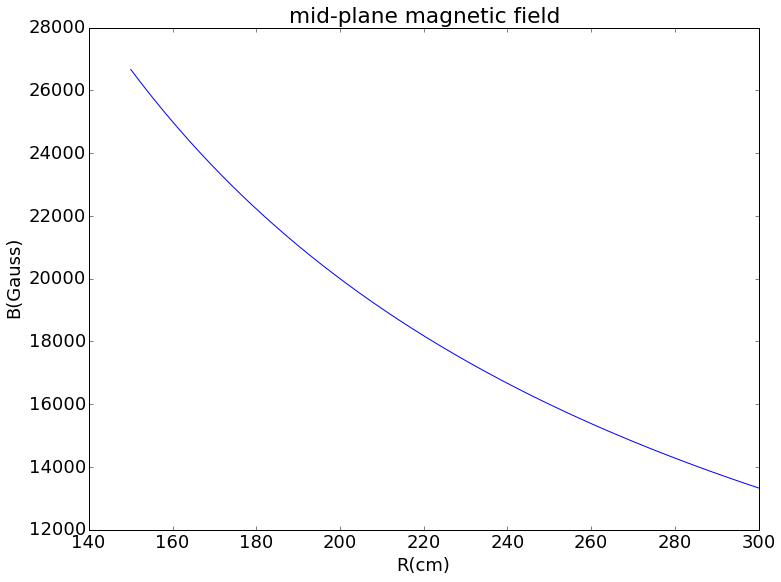

In [6]:
plt.figure()
plt.plot(R1D, p2d_uni.B0[mid_Z, :])
plt.title('mid-plane magnetic field')
plt.ylabel('B(Gauss)')
plt.xlabel('R(cm)')

And some relevent frequencies:

In [7]:
pcpr = pc.PlasmaCharProfile(p2d_uni)

C:\Users\lei\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


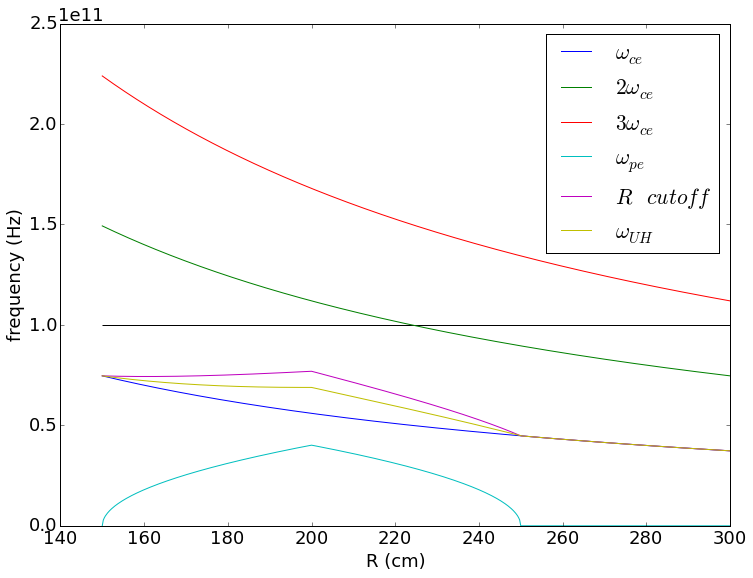

In [8]:
omega = 1e11*twopi
plt.figure()
plt.plot(R1D, pcpr.omega_ce[mid_Z, :]/twopi, label='$\omega_{ce}$')
plt.plot(R1D, 2*pcpr.omega_ce[mid_Z, :]/twopi, label='$2\omega_{ce}$')
plt.plot(R1D, 3*pcpr.omega_ce[mid_Z, :]/twopi, label='$3\omega_{ce}$')
plt.plot(R1D, pcpr.omega_pe[mid_Z, :]/twopi, label='$\omega_{pe}$')
plt.plot(R1D, pcpr.omega_R[mid_Z, :]/twopi, label='$R \; cutoff$')
plt.plot(R1D, pcpr.omega_UH[mid_Z, :]/twopi, label='$\omega_{UH}$')
plt.hlines(y=omega/twopi, xmin=150, xmax=300)
plt.legend(loc='best')
plt.ylabel('frequency (Hz)')
plt.xlabel('R (cm)')

# 2. Test Case 1. Converging Beam

Strongly converging beams are of particular interests because they have narrow waist, so may provide good resolution in Y and Z directions. We will use a Gaussian beam with waist width equals 2 times vacuum wavelength:
$$w_{0y} = w_{z0} = 2\lambda$$

In [9]:
omega = twopi*1e11
k = omega/c
wave_length = twopi/k
print('lambda = {0:.3}cm'.format(wave_length))

lambda = 0.3cm


In [10]:
detector = GaussianAntenna(omega_list=[omega], k_list=[k], power_list=[1], waist_x=220, waist_y=0, w_0y=2*wave_length)

In [11]:
detector.central_beam.reighlay_range

(3.7672722464787363, 3.7672722464787363)

In [12]:
detector.central_beam.divergence

(0.15915494309189535, 0.15915494309189535)

In [13]:
ece = rcp.ECE2D(p2d_uni, detector, polarization='X', max_harmonic=4, max_power=4, 
                weakly_relativistic=True, isotropic=True)

Propagator 2D initialized.


In [14]:
X1D = np.linspace(251, 210, 100)
Y1D = np.linspace(-20, 20, 129)
Z1D = np.linspace(-20, 20, 129)

In [15]:
ece.set_coords([Z1D, Y1D, X1D])

In [16]:
ece.auto_adjust_mesh()

Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 56.85s


In [17]:
ece.view_point

(0.0, 0.0, 221.18181818181819)

In [18]:
ece.diag_x

([222.83838383838383], [2.7609427609427635])

In [19]:
Te = ece.diagnose()

Diagnose starts.
f = 100.0GHz starts.
Walltime: 74.58s


In [20]:
Te/keV

9.9945949828941725

C:\Users\lei\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


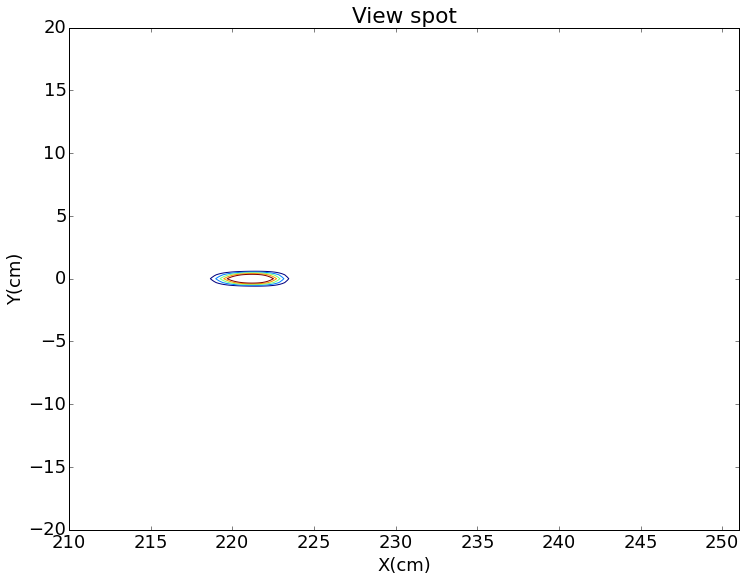

In [21]:
plt.contour(ece.X1D, ece.Y1D, ece.view_spot, np.linspace(0.5,1.5,5)*0.368*np.max(ece.view_spot))
plt.title('View spot')
plt.xlabel('X(cm)')
plt.ylabel('Y(cm)')

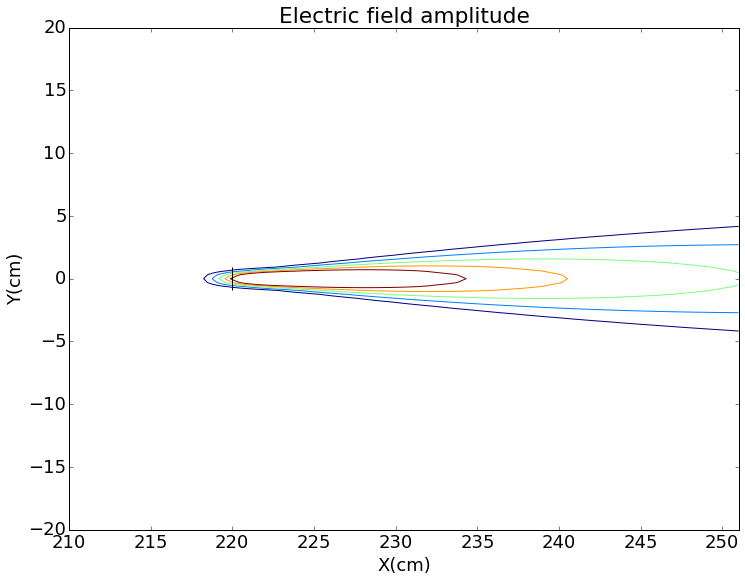

In [22]:
E = ece.propagator.E[0,:,::2]
plt.contour(ece.X1D, ece.Y1D, np.abs(E), np.linspace(0.5,1.5,5)*0.368*np.max(np.abs(E)))
plt.vlines(x=220, ymin=-3*wave_length, ymax=3*wave_length)
plt.title('Electric field amplitude')
plt.ylabel('Y(cm)')
plt.xlabel('X(cm)')

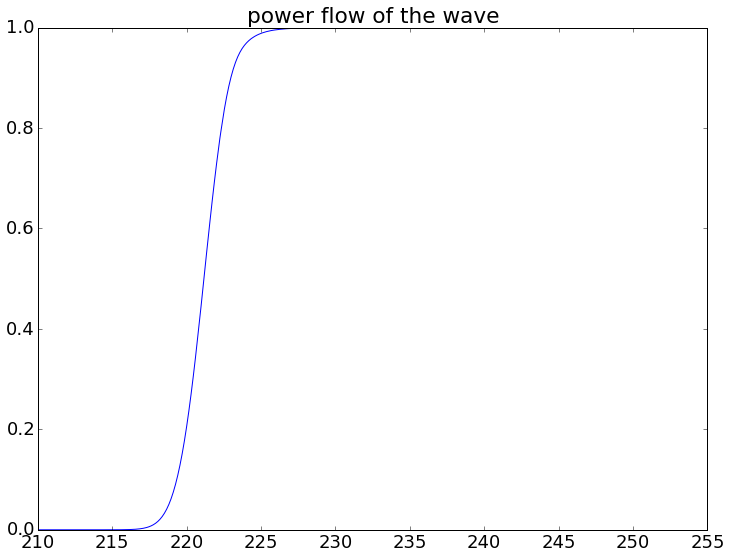

In [23]:
pf = ece.propagator.power_flow
plt.plot(ece.propagator.calc_x_coords, np.abs(pf))
plt.title('power flow of the wave')

# 3. Test Case 2. Near Cutoff Behavior

When electron density increases, the R-cutoff frequency and electron plasma frequency will rise. They corresponds to X-mode and O-mode cutoff respectively. When waves approaches cutoff, $k_x \to 0$, some of the assumptions made in our paraxial propagator will be invalid. Namely, they are:
- Paraxial assumption: $|k_y/k_x| \ll 1 $ and $|k_z/k_x|\ll 1$. The boundary where this assumption starts to fail depends on the incidental angle of the main ray, as well as the spread of the whole beam. 
- WKB assumption: $|k_x'/k_x^2| \ll 1$. For a linear density profile, let $L$ be the gradient length scale at the cutoff location, i.e. $L = n_c/\nabla n$. We can show that this criteria reduces to the requirement $x \gg \sqrt{\lambda_0 L/2\pi}$, where $x$ is the distance from cutoff, and $\lambda_0$ is the wave length in vacuum.

In [24]:
# We use a higher electron density to investigate the near cutoff behavior of our propagator and ECE2D modules
ne0_high = 8e13
tp.set_parameter1D(Te_0 = Te0, ne_0=ne0_high, Te_shape='uniform', 
                   ne_shape='linear', R_0=1000, Xmin=950, Xmax=1100)
p1d_high = tp.create_profile1D()

from FPSDP.Geometry.Grid import Cartesian2D
grid_h = Cartesian2D(DownLeft=(-50, 950), UpRight=(50, 1100), NR=301, NZ=201)
mid_Zh = grid_h.NZ/2
p2d_high = tp.simulate_1D(p1d=p1d_high, grid2D=grid_h)
p2d_high.setup_interps()

ne0_sp has not been created. Temperary interpolator generated. If this message shows up a lot of times, please consider calling setup_interps function first.
B0_sp has not been created. Temperary interpolator generated. If this message shows up a lot of times, please consider calling setup_interps function first.
Te0_sp has not been created. Temperary interpolator generated. If this message shows up a lot of times, please consider calling setup_interps function first.


In [25]:
pcpr_h = pc.PlasmaCharProfile(p2d_high)

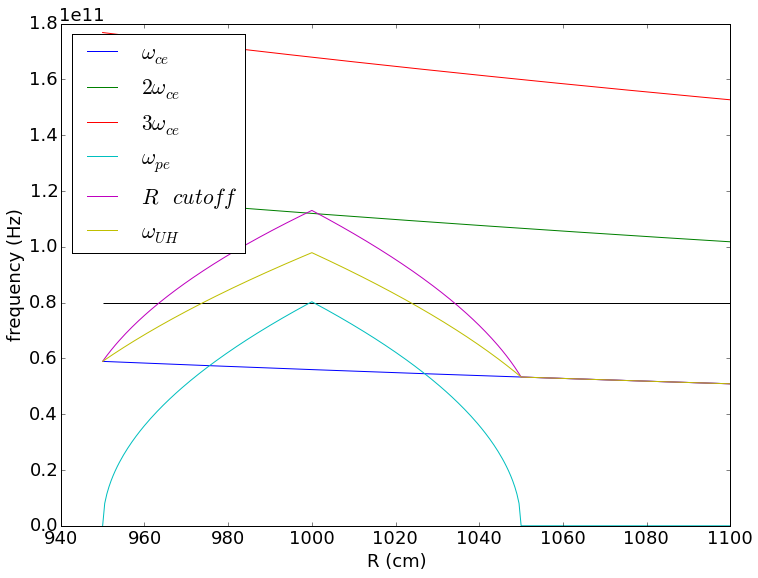

In [55]:
omega = 0.8e11*twopi
k = omega/c
R1D = p2d_high.grid.R1D
plt.figure()
plt.plot(R1D, pcpr_h.omega_ce[mid_Zh, :]/twopi, label='$\omega_{ce}$')
plt.plot(R1D, 2*pcpr_h.omega_ce[mid_Zh, :]/twopi, label='$2\omega_{ce}$')
plt.plot(R1D, 3*pcpr_h.omega_ce[mid_Zh, :]/twopi, label='$3\omega_{ce}$')
plt.plot(R1D, pcpr_h.omega_pe[mid_Zh, :]/twopi, label='$\omega_{pe}$')
plt.plot(R1D, pcpr_h.omega_R[mid_Zh, :]/twopi, label='$R \; cutoff$')
plt.plot(R1D, pcpr_h.omega_UH[mid_Zh, :]/twopi, label='$\omega_{UH}$')
plt.hlines(y=omega/twopi, xmin=np.min(R1D), xmax=np.max(R1D))
plt.legend(loc='best')
plt.ylabel('frequency (Hz)')
plt.xlabel('R (cm)')

## 3.1 Finite $k_z$

We will use a weakly diverging beam with a significant horizontal incident angle. So central $k_z$ is finite, but k_z spread is small.  

In [56]:
theta_h = pi/10

In [57]:
detector = GaussianAntenna(omega_list=[omega], k_list=[k], power_list=[1], waist_x=1050, 
                           waist_y=0, w_0y=10*wave_length, tilt_h=theta_h)

In [58]:
k_z_central = k*np.sin(theta_h)
print('central k_z:', k_z_central)

central k_z: 5.18125631602


Due to our choice of omega and B field profile, we are far away from ECE resonance. We can focus on the wave propagation pattern.

In [59]:
ece_h = rcp.ECE2D(p2d_high, detector, polarization='X', max_harmonic=2, max_power=2, 
                weakly_relativistic=True, isotropic=True)

Propagator 2D initialized.


In [60]:
X1D = np.linspace(1051, 1034, 200)
Y1D = np.linspace(-20, 20, 129)
Z1D = np.linspace(-10, 20, 1025)

In [61]:
ece_h.set_coords([Z1D, Y1D, X1D])

In [62]:
ece_h.diagnose()

Diagnose starts.
f = 80.0GHz starts.
Walltime: 15.9s


1.4677493029600836e-10

In [63]:
ece_h.Te/keV

0.091608369926356487

In [64]:
prop = ece_h.propagator
E = np.fft.ifft(prop.E, axis=0)

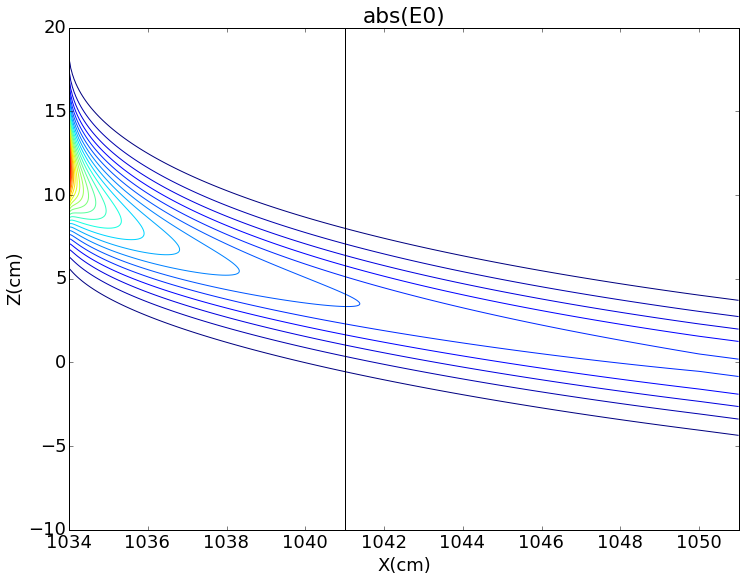

In [65]:
plt.contour(prop.calc_x_coords, prop.z_coords, np.abs(E[:,64,:]), 30)
plt.vlines(x=[1041], ymin=-10, ymax=20)
plt.title('abs(E0)')
plt.ylabel('Z(cm)')
plt.xlabel('X(cm)')

In [66]:
prop._generate_main_phase()
main_phase = prop.main_phase

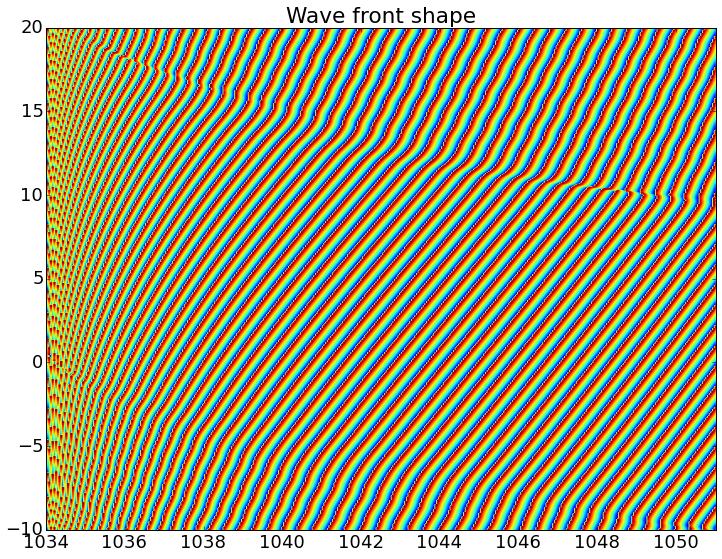

In [67]:
plt.contour(prop.calc_x_coords, prop.z_coords, np.angle(E[:,64,:]*np.exp(1j*main_phase)), 30)
plt.title('Wave front shape')

If we look at the main wave vector.

In [68]:
print('central_kz:{0:.3}, delta_kz:{1:.3}'.format(prop.central_kz[0,0], prop.delta_kz[0,0]))

central_kz:5.23, delta_kz:1.67


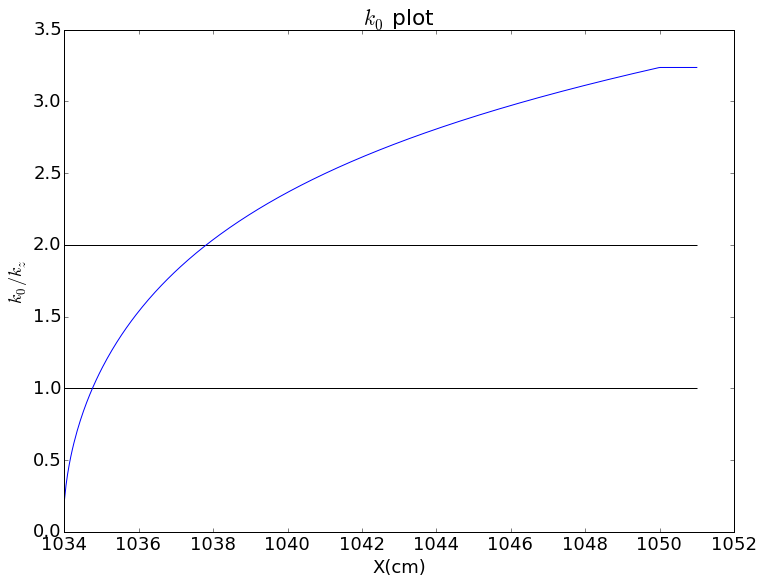

In [69]:
plt.plot(prop.calc_x_coords, np.abs(prop.k_0)/k_z_central)
plt.hlines(y=[1,2], xmin=1034, xmax=1051)
plt.title('$k_0$ plot')
plt.ylabel('$k_0/k_z$')
plt.xlabel('X(cm)')

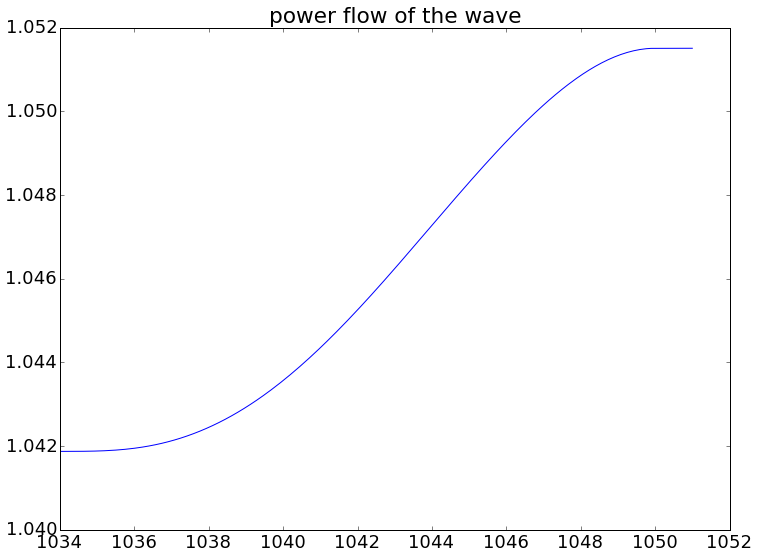

In [70]:
pf = prop.power_flow
plt.plot(prop.calc_x_coords, np.abs(pf))
plt.title('power flow of the wave')

## 3.2 Finite $k_x'/k_x^2$

Using the settings above, we propagate a perpendicularly incident wave instead, and take a look at the $k_x'/k_x^2$ term effect.

In [71]:
detector = GaussianAntenna(omega_list=[omega], k_list=[k], power_list=[1], waist_x=1050, 
                           waist_y=0, w_0y=20*wave_length, tilt_h=0)

In [72]:
ece_p = rcp.ECE2D(p2d_high, detector, polarization='X', max_harmonic=2, max_power=2, 
                weakly_relativistic=True, isotropic=True)

Propagator 2D initialized.


In [73]:
X1D = np.linspace(1051, 1034, 300)
Y1D = np.linspace(-20, 20, 129)
Z1D = np.linspace(-20, 20, 129)

In [74]:
ece_p.set_coords([Z1D, Y1D, X1D])

In [75]:
ece_p.diagnose()

Diagnose starts.
f = 80.0GHz starts.
Walltime: 12.73s


4.1016944396304111e-12

In [76]:
prop = ece_p.propagator
E = np.fft.ifft(prop.E, axis=0)

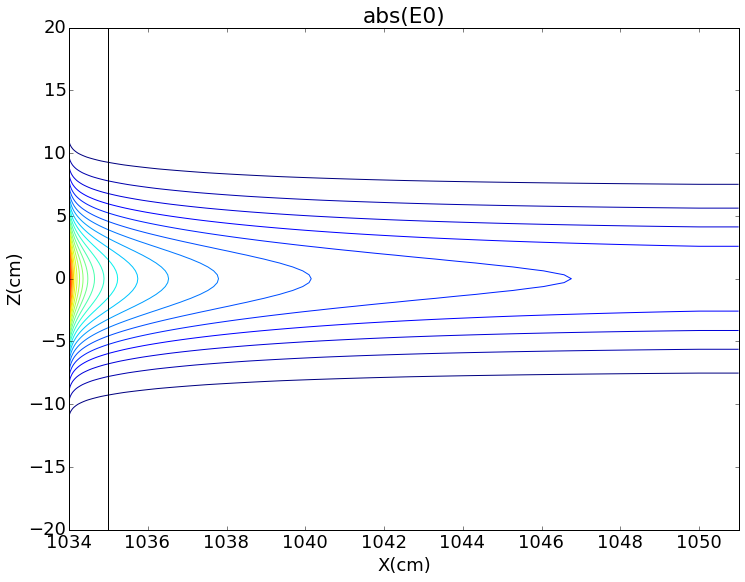

In [77]:
plt.contour(prop.calc_x_coords, prop.z_coords, np.abs(E[:,64,:]), 30)
plt.vlines(x=[1035], ymin=-20, ymax=20)
plt.title('abs(E0)')
plt.ylabel('Z(cm)')
plt.xlabel('X(cm)')

In [78]:
prop._generate_main_phase()
main_phase = prop.main_phase

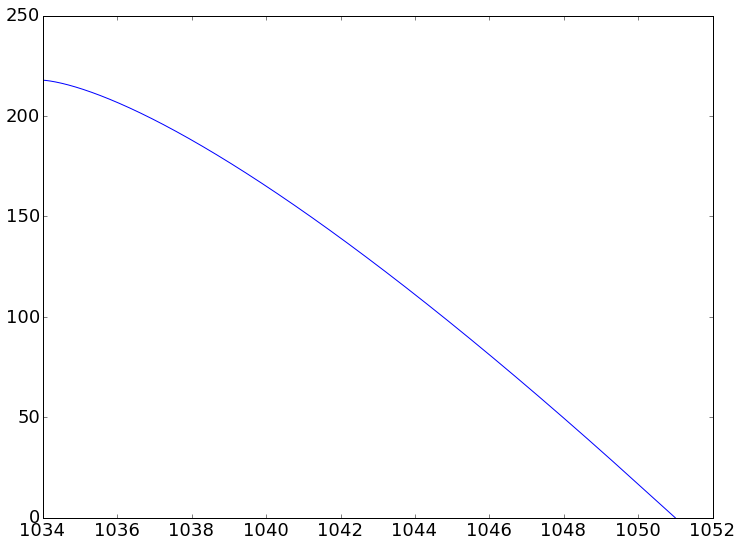

In [79]:
plt.plot(prop.calc_x_coords, main_phase)

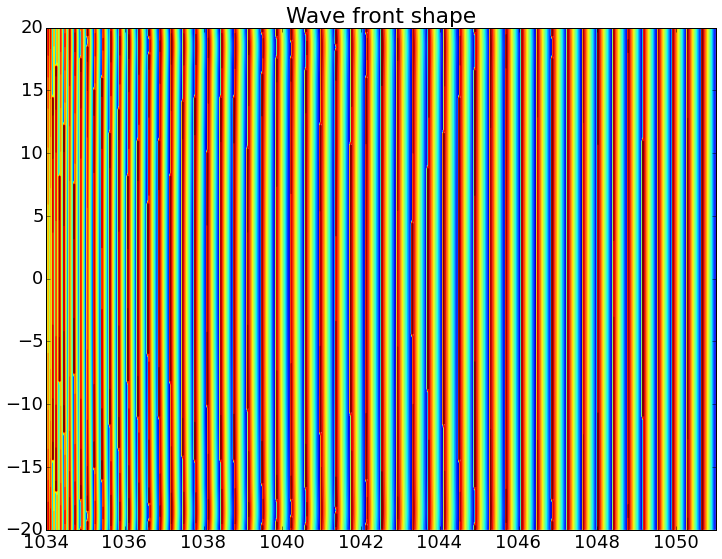

In [80]:
plt.contour(prop.calc_x_coords, prop.z_coords, np.angle(E[:,64,:]*np.exp(1j*main_phase)), 30)
plt.title('Wave front shape')

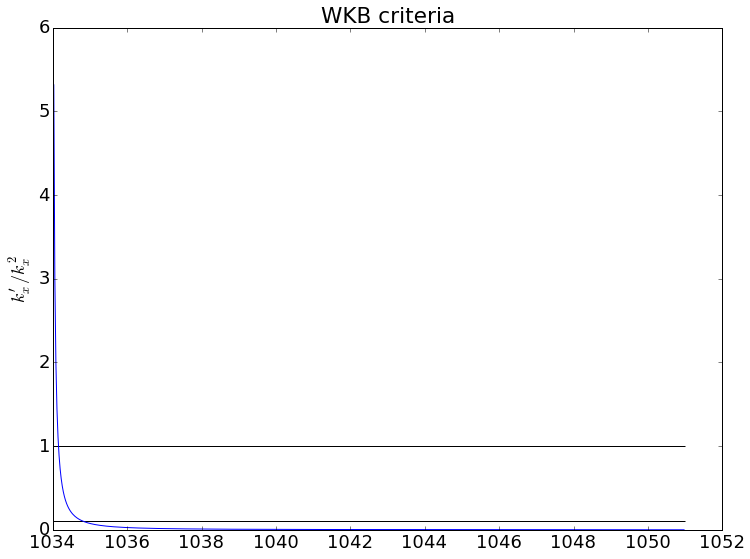

In [81]:
k0 = np.abs(prop.k_0)
dx = np.abs(prop.calc_x_coords[1] - prop.calc_x_coords[0])
kp = (k0[2:]-k0[:-2])/(2*dx)
WKB_term = np.abs(kp/(k0[1:-1]*k0[1:-1]))
plt.plot(prop.calc_x_coords[1:-1], WKB_term)
plt.hlines(y=[1, 0.1], xmin=1034, xmax=1051)
plt.title('WKB criteria')
plt.ylabel('$k_x\'/k_x^2$')

In [82]:
lambd = twopi*c/omega
np.sqrt(16*lambd/twopi)

0.97686294217274217

The area where WKB approximation fails roughly agrees with our estimation. 

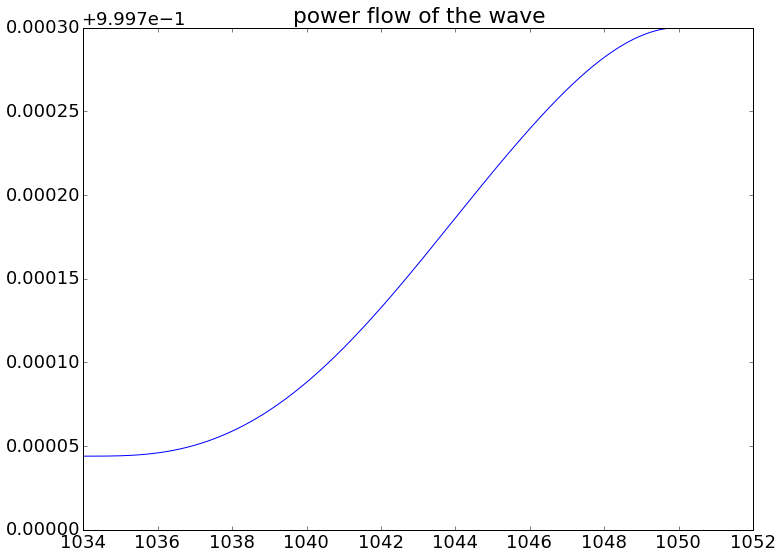

In [83]:
pf = prop.power_flow
plt.plot(prop.calc_x_coords, np.abs(pf))
plt.title('power flow of the wave')